In [2]:
import time
import pandas as pd
import psycopg2
import datetime
from tqdm import trange

In [3]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 
# %matplotlib inline 
import platform
from matplotlib import font_manager, rc # plt.rcParams['axes.unicode_minus'] = False 
if platform.system() == 'Darwin': rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf" 
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name) 
else: 
    print('Unknown system... sorry~~~~')

    # row 생략 없이 출력
pd.set_option('display.max_rows', 1000)
# col 생략 없이 출력
pd.set_option('display.max_columns', 1000)
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2

In [4]:
# DB 연결 부분
uswer = 'dt.intern'
host = '10.80.0.234'
port = '5439'
dbname = 'fnf'
con = psycopg2.connect(dbname='fnf',host='10.80.0.234', port='5439', user = 'dt.intern', password='DTintn0926')
cur = con.cursor()

# 운동화 선택 

In [5]:
# 2019년 - 2020년 / 디스커버리 / SH(운동화) 를 가지고 있는 매장 선택
start = time.time()

total_shop_stock_ori = '''
SELECT vfs.weekkey,vfs.shopkey ,vfs.partkey,vfs.scskey,vfs.brand,vfs.season,vfs.partcode,vfs.color,vfs.siz,vfs.week_takeout_qty,vfs.takeout_qty ,vfs.week_sale_qty ,vfs.sale_qty,vfs.week_sale_amt,vfs.stock_qty ,vfs.sale_amt,prdt.gender 
FROM ax.vw_f_scsshopweek vfs
INNER JOIN ax.vw_d_prdt prdt ON vfs.scskey  = prdt.scskey
WHERE vfs.brand = 'X' AND vfs.weekkey BETWEEN '2019-01-01' AND '2020-12-31' AND prdt.item ='SH'
'''

cur.execute(total_shop_stock_ori)
total_shop_stock_ori = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 51.312923192977905


In [6]:
total_shop_stock_ori = pd.DataFrame(total_shop_stock_ori)
total_shop_stock_ori.columns = ['weekkey','shopkey','partkey','scskey','brand','season','partcode','color','siz','week_takeout_qty','takeout_qty' ,'week_sale_qty' ,'sale_qty','week_sale_amt','stock_qty' ,'sale_amt','gender']

In [7]:
total_shop_stock = total_shop_stock_ori

# 매장 선택

In [8]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_list = '''
SELECT shop_2019.shopkey 
FROM(SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%'  AND vds.brand = 'X' AND (closedate > '2019-12-31' OR closedate is NULL ) AND opendate < '2019-01-01'
LIMIT 1000) AS shop_2019
INNER JOIN (SELECT *
FROM ax.vw_d_shop vds
WHERE type_ax_zone_nm ='국내' AND  vds.chnl_type_sfdc ='오프라인' AND shop_nm NOT LIKE '%아울렛%' AND shop_type_sfdc NOT LIKE '%상설%' AND vds.brand = 'X' AND (closedate > '2020-12-31' OR closedate is NULL ) AND opendate < '2020-01-01'
) AS shop_2020
ON shop_2019.shopkey =shop_2020.shopkey
'''

cur.execute(shop_list)
shop_list = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1.0379390716552734


In [9]:
shop_list_pd = pd.DataFrame(shop_list)
shop_list_pd.columns = ['shopkey']

In [10]:
len(shop_list_pd['shopkey'].unique())

143

In [11]:
# 매장정보

In [12]:
# 국내 / 오프라인 / 아울렛,상설 x / 디스커버리 / 2019년 - 2020년 전 기간 운영한 매장 

start = time.time()

shop_info = '''
SELECT shopkey ,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
FROM ax.vw_d_shop
WHERE type_ax_zone_nm ='국내' AND chnl_type_sfdc='오프라인'
;
'''

cur.execute(shop_info)
shop_info = cur.fetchall()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.41960859298706055


In [13]:
shop_info_pd = pd.DataFrame(shop_info)
shop_info_pd.columns = ['shopkey' ,'shop_nm','shop_nm_sfdc','repr_shopcode','type_shop_nm','type_contract_nm','type_zone_nm','region_nm']

## 매장 선택 및 연도별 분리

In [14]:
total_shop_stock1920 = total_shop_stock[total_shop_stock['weekkey']> datetime.date(2018,12,31) ]

In [15]:
total_shop_stock1920

,weekkey,shopkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
0,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR190,X,18F,DKSH64841,GR,190,0,1,1,1,55300.00,0,55300.00,X
1,2019-04-15,X10065,X18FDKSH64841,X18FDKSH64841GR200,X,18F,DKSH64841,GR,200,1,3,1,1,55300.00,2,55300.00,X
2,2020-01-13,X10065,X18FDKSH64841,X18FDKSH64841MG210,X,18F,DKSH64841,MG,210,0,8,2,5,63200.00,3,181700.00,X
3,2020-03-09,X10065,X18FDKSH64841,X18FDKSH64841MG210,X,18F,DKSH64841,MG,210,-1,5,0,5,0.00,0,181700.00,X
4,2019-02-11,X10003,X18FDXSH09841,X18FDXSH09841WH250,X,18F,DXSH09841,WH,250,1,1,0,1,0.00,0,90300.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375435,2020-11-23,X10056,X21SDXSH7D111,X21SDXSH7D111BE250,X,21S,DXSH7D111,BE,250,1,1,0,0,0.00,1,0.00,X
2375436,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE230,X,21S,DXSH7E111,YE,230,1,1,0,0,0.00,1,0.00,X
2375437,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE240,X,21S,DXSH7E111,YE,240,1,1,0,0,0.00,1,0.00,X
2375438,2020-11-23,X10056,X21SDXSH7E111,X21SDXSH7E111YE260,X,21S,DXSH7E111,YE,260,1,1,0,0,0.00,1,0.00,X


In [16]:
df_INNER_JOIN = pd.merge(shop_list_pd, total_shop_stock1920, left_on='shopkey', right_on='shopkey', how='inner')

In [17]:
shop_stock_2019 = df_INNER_JOIN[df_INNER_JOIN['weekkey']< datetime.date(2020,1,1) ]
shop_stock_2020 = df_INNER_JOIN[df_INNER_JOIN['weekkey']> datetime.date(2019,12,31) ]

In [18]:
# 전체 날짜별 사이즈 확인
stock_2019 = shop_stock_2019.groupby(['weekkey','siz']).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','siz']).sum()


# stock_2020 = shop_stock_2020.groupby(['weekkey','color']).sum()

In [19]:
stock_df_2019 = stock_2019.reset_index()
stock_df_2020 = stock_2020.reset_index()

In [20]:
siz_list_2019 = sorted(stock_df_2019['siz'].unique())
siz_list_2020 = sorted(stock_df_2020['siz'].unique())

In [21]:
main_siz_list = ['225','230','240','250','260','270','280','290']

225


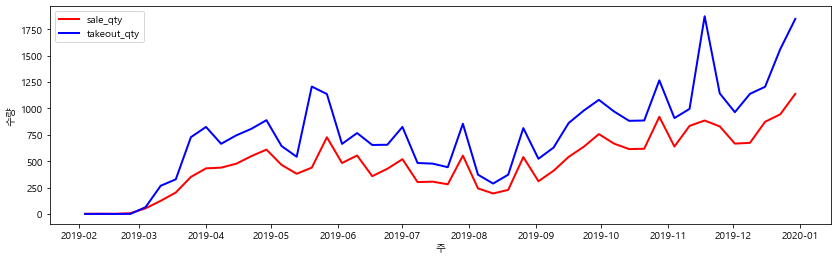

230


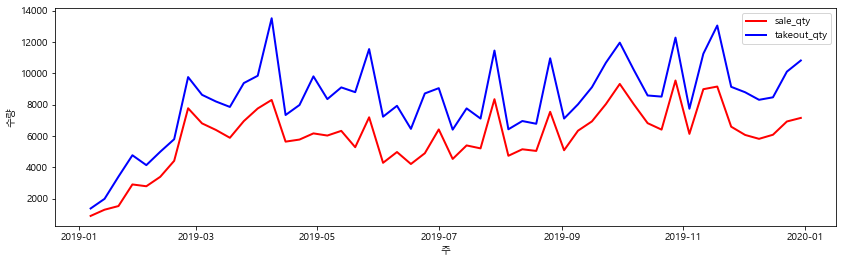

240


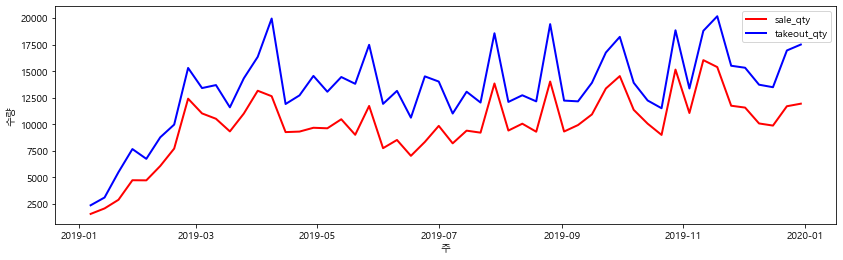

250


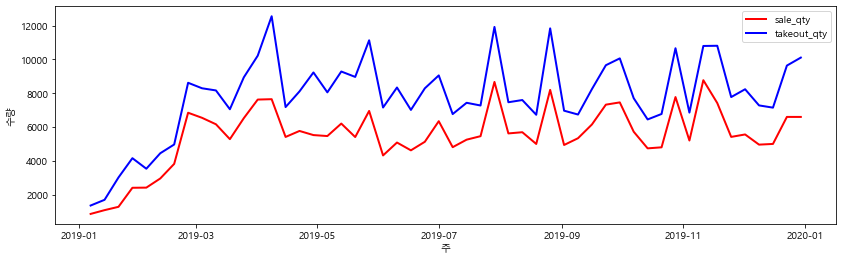

260


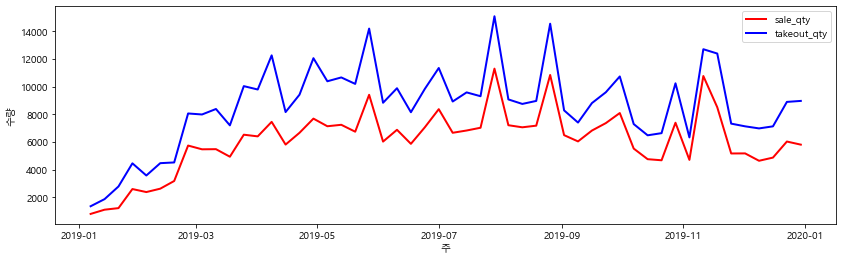

270


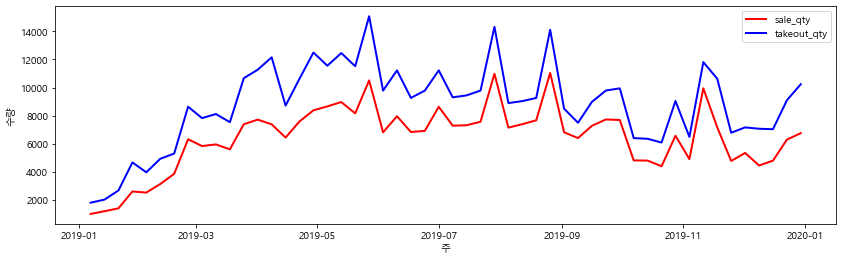

280


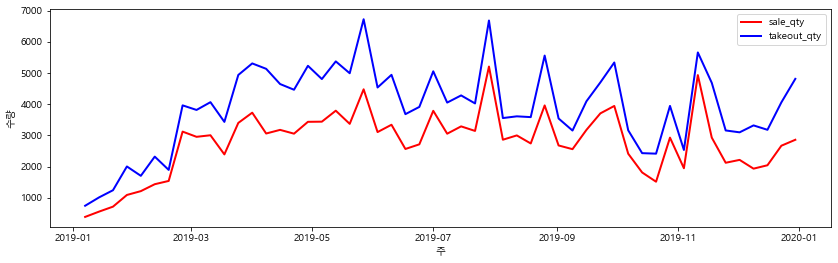

290


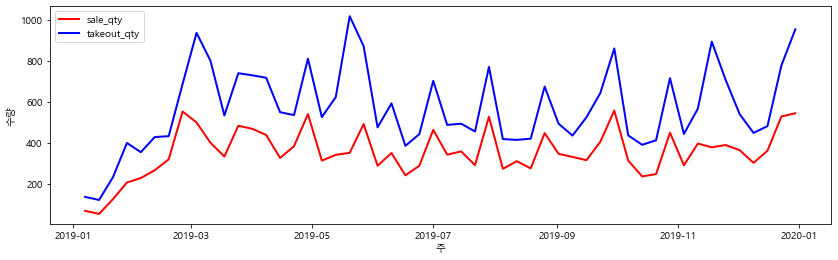

In [119]:
# 사이즈별 총 재고와 총 판매 그래프 
for i in main_siz_list:
    print(i)
    plt.plot(stock_df_2019[stock_df_2019['siz']==i]['weekkey'], stock_df_2019[stock_df_2019['siz']==i]['sale_qty'],'r')
    plt.plot(stock_df_2019[stock_df_2019['siz']==i]['weekkey'], stock_df_2019[stock_df_2019['siz']==i]['takeout_qty'],'b')
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [ ]:
stock_df_2019.to_csv('stock_df_2019.csv')

In [157]:
stock_df_2020.to_csv('stock_df_2020.csv')

In [124]:
stock_df_2019

,weekkey,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
17,2019-01-07,290,58,137,20,69,68
37,2019-01-14,290,64,122,33,54,68
56,2019-01-21,290,68,233,51,126,107
76,2019-01-28,290,134,400,62,207,193
97,2019-02-04,290,97,355,101,229,126
118,2019-02-11,290,123,429,83,267,162
138,2019-02-18,290,74,433,88,320,113
159,2019-02-25,290,72,688,152,553,135
180,2019-03-04,290,386,937,113,500,437
201,2019-03-11,290,250,801,80,401,400


In [126]:
stock_2019.corr()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
week_takeout_qty,1.000000,0.426671,0.475673,0.369910,0.491353
takeout_qty,0.426671,1.000000,0.688431,0.981523,0.768592
week_sale_qty,0.475673,0.688431,1.000000,0.707044,0.424361
sale_qty,0.369910,0.981523,0.707044,1.000000,0.631981
stock_qty,0.491353,0.768592,0.424361,0.631981,1.000000


In [125]:
stock_2019.corr().to_csv('stock_2019_corr.csv')

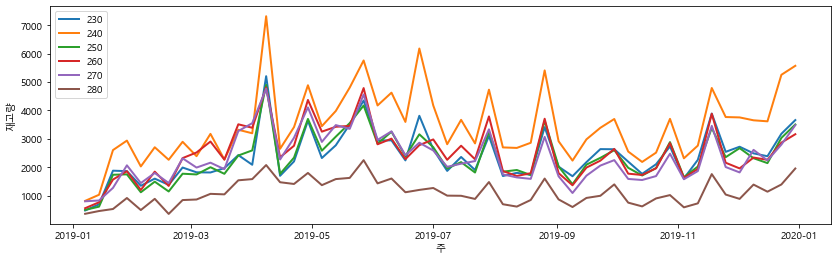

In [24]:
# 재고량
plt.plot(stock_df_2019[stock_df_2019['siz']=='230']['weekkey'], stock_df_2019[stock_df_2019['siz']=='230']['stock_qty'],label='230')
plt.plot(stock_df_2019[stock_df_2019['siz']=='240']['weekkey'], stock_df_2019[stock_df_2019['siz']=='240']['stock_qty'],label='240')
plt.plot(stock_df_2019[stock_df_2019['siz']=='250']['weekkey'], stock_df_2019[stock_df_2019['siz']=='250']['stock_qty'],label='250')
plt.plot(stock_df_2019[stock_df_2019['siz']=='260']['weekkey'], stock_df_2019[stock_df_2019['siz']=='260']['stock_qty'],label='260')
plt.plot(stock_df_2019[stock_df_2019['siz']=='270']['weekkey'], stock_df_2019[stock_df_2019['siz']=='270']['stock_qty'],label='270')
plt.plot(stock_df_2019[stock_df_2019['siz']=='280']['weekkey'], stock_df_2019[stock_df_2019['siz']=='280']['stock_qty'],label='280')
plt.legend([230,240,250,260,270,280])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

C:\Users\AD0486\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AD0486\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


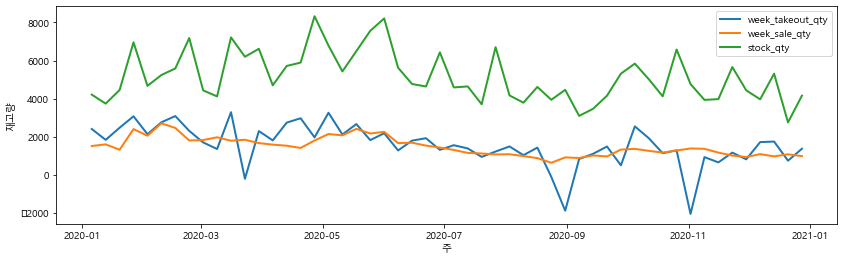

In [155]:
# 재고량
plt.plot(stock_df_2020[stock_df_2020['siz']=='240']['weekkey'], stock_df_2020[stock_df_2020['siz']=='240']['week_takeout_qty'],label='230')
plt.plot(stock_df_2020[stock_df_2020['siz']=='240']['weekkey'], stock_df_2020[stock_df_2020['siz']=='240']['week_sale_qty'],label='230')
plt.plot(stock_df_2020[stock_df_2020['siz']=='240']['weekkey'], stock_df_2020[stock_df_2020['siz']=='240']['stock_qty'],label='240')

plt.legend(['week_takeout_qty','week_sale_qty','stock_qty'])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

C:\Users\AD0486\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\AD0486\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


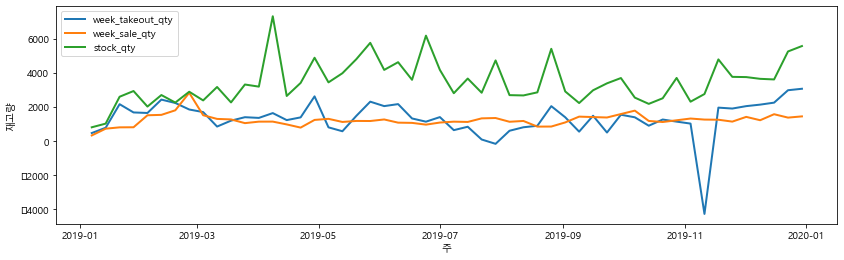

In [156]:
# 재고량
plt.plot(stock_df_2019[stock_df_2019['siz']=='240']['weekkey'], stock_df_2019[stock_df_2019['siz']=='240']['week_takeout_qty'],label='230')
plt.plot(stock_df_2019[stock_df_2019['siz']=='240']['weekkey'], stock_df_2019[stock_df_2019['siz']=='240']['week_sale_qty'],label='230')
plt.plot(stock_df_2019[stock_df_2019['siz']=='240']['weekkey'], stock_df_2019[stock_df_2019['siz']=='240']['stock_qty'],label='240')

plt.legend(['week_takeout_qty','week_sale_qty','stock_qty'])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

In [149]:
stock_df_2020[stock_df_2020['weekkey'] > datetime.date(2020,8,1) ]

,weekkey,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
587,2020-08-03,180,4,9,5,7,2
588,2020-08-03,190,11,31,8,19,12
589,2020-08-03,200,17,54,16,35,19
590,2020-08-03,210,19,94,15,58,36
591,2020-08-03,220,99,485,45,330,155
592,2020-08-03,225,-41,1345,58,1039,306
593,2020-08-03,230,1218,13985,722,11119,2866
594,2020-08-03,235,485,6884,259,5359,1525
595,2020-08-03,240,1478,23665,1068,19503,4162
596,2020-08-03,245,324,5356,221,4302,1054


In [150]:
stock_df_2019[stock_df_2019['weekkey'] > datetime.date(2019,8,1) ]

,weekkey,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
617,2019-08-05,160,-13,19,2,15,4
618,2019-08-05,170,-20,10,0,6,4
619,2019-08-05,180,-34,44,3,16,28
620,2019-08-05,190,-42,57,7,19,38
621,2019-08-05,200,-58,123,8,74,49
622,2019-08-05,210,-37,54,2,18,36
623,2019-08-05,220,-20,18,0,12,6
624,2019-08-05,225,50,372,50,242,130
625,2019-08-05,230,329,6433,662,4744,1689
626,2019-08-05,235,30,2378,132,1765,613


In [25]:
stock_df_sum_2019 = stock_df_2019.groupby(['weekkey']).sum()

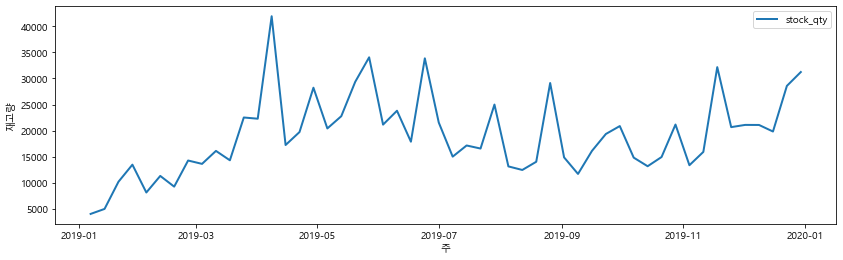

In [26]:
# 재고량
plt.plot(stock_df_sum_2019.index, stock_df_sum_2019['stock_qty'])
plt.legend(['stock_qty'])
plt.xlabel('주')
plt.ylabel('재고량')
plt.show()

# 2019/2020 비교 

In [27]:
stock_2019 = shop_stock_2019.groupby(['weekkey','shopkey',]).sum()
stock_2020 = shop_stock_2020.groupby(['weekkey','shopkey']).sum()

In [28]:
stock_2019 = stock_2019.reset_index()
stock_2020 = stock_2020.reset_index()

In [29]:
shop_key_list = stock_2020['shopkey'].unique()

In [30]:
stock_sum_2019 = []
stock_sum_2020 = []
stock_plus_2019 = []
stock_takeout_2019 = []
stock_takeout_2020 = []
stock_sale_2019 = []
stock_sale_2020 = []
stock_ratio_2019=[]
stock_ratio_2020=[]
sale_takeout_2019=[]
sale_takeout_2020=[]

for i in shop_key_list:
    stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum())
    stock_plus_2019.append( round(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()*1.2))
    stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['week_sale_qty'].sum())
    stock_takeout_2019.append(stock_2019[stock_2019['shopkey']==i]['week_takeout_qty'].sum())
    stock_takeout_2020.append(stock_2020[stock_2020['shopkey']==i]['week_takeout_qty'].sum())
#     stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['sale_qty'].sum())
#     stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['sale_qty'].sum())
    stock_ratio_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['stock_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['takeout_qty'])
    stock_ratio_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['stock_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['takeout_qty'])
    sale_takeout_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['week_sale_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['week_takeout_qty'])
    sale_takeout_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['week_sale_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['week_takeout_qty'])

#     stock_ratio_2019.append( stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()/ )
#     stock_ratio_2020.append()
#     break
    

In [164]:
stock_sum_2019 = []
stock_sum_2020 = []
stock_plus_2019 = []
stock_takeout_2019 = []
stock_takeout_2020 = []
stock_sale_2019 = []
stock_sale_2020 = []
stock_ratio_2019=[]
stock_ratio_2020=[]
sale_takeout_2019=[]
sale_takeout_2020=[]

for i in shop_key_list:
    stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum())
    stock_plus_2019.append( round(stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()*1.2))
    stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['week_sale_qty'].sum())
    stock_takeout_2019.append(stock_2019[ (stock_2019['shopkey']==i) & (stock_2019['week_takeout_qty']>0) ]['week_takeout_qty'].sum())
    stock_takeout_2020.append(stock_2020[(stock_2020['shopkey']==i) & (stock_2020['week_takeout_qty']>0)]['week_takeout_qty'].sum())
#     stock_sale_2019.append(stock_2019[stock_2019['shopkey']==i]['sale_qty'].sum())
#     stock_sale_2020.append(stock_2020[stock_2020['shopkey']==i]['sale_qty'].sum())
    stock_ratio_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['stock_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['takeout_qty'])
    stock_ratio_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['stock_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['takeout_qty'])
    sale_takeout_2019.append(stock_2019[stock_2019['shopkey']==i].sum()['week_sale_qty'] / stock_2019[stock_2019['shopkey']==i].sum()['week_takeout_qty'])
    sale_takeout_2020.append(stock_2020[stock_2020['shopkey']==i].sum()['week_sale_qty'] / stock_2020[stock_2020['shopkey']==i].sum()['week_takeout_qty'])

#     stock_ratio_2019.append( stock_2019[stock_2019['shopkey']==i]['week_sale_qty'].sum()/ )
#     stock_ratio_2020.append()
#     break
    

In [165]:
df = pd.DataFrame(
                {'shopkey' : shop_key_list,
                 '주 별 총 판매량(2019)' : stock_sale_2019,
                '주 별 총 판매량(2020)' : stock_sale_2020,
                '주 별 총 입고량(2019)':stock_takeout_2019,
                 '주 별 총 입고량(2020)':stock_takeout_2020,
#                  'stock_plus_2019' : stock_plus_2019,
#                  'stock_takeout_2020':stock_takeout_2020,
#                  'stock_sale_2020':stock_sale_2020,
#                  '2019_재고비율':stock_ratio_2019,
#                  '2020_재고비율':stock_ratio_2020,
#                  '2019_판매_입고 비율':sale_takeout_2019,
#                  '2020_판매_입고 비율':sale_takeout_2020
                },
                )

df

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020)
0,X10003,2312,3816,2866,4374
1,X10004,4745,4013,5266,4197
2,X10005,2123,2429,2663,2755
3,X10006,4603,8136,5285,8376
4,X10007,4426,6249,5064,6705
5,X10008,8846,5640,9569,5746
6,X10009,5645,4432,6417,4856
7,X10011,3986,3326,4617,3700
8,X10014,2882,3619,3528,4034
9,X10015,1554,2220,1984,2774


In [166]:
df['판매수량 비율(20/19)'] = df['주 별 총 판매량(2020)'] / df['주 별 총 판매량(2019)']

In [167]:
df['입고수량 비율(20/19)'] = df['주 별 총 입고량(2020)'] / df['주 별 총 입고량(2019)']

In [168]:
df

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19)
0,X10003,2312,3816,2866,4374,1.650519,1.526169
1,X10004,4745,4013,5266,4197,0.845732,0.797000
2,X10005,2123,2429,2663,2755,1.144136,1.034548
3,X10006,4603,8136,5285,8376,1.767543,1.584863
4,X10007,4426,6249,5064,6705,1.411884,1.324052
5,X10008,8846,5640,9569,5746,0.637576,0.600481
6,X10009,5645,4432,6417,4856,0.785120,0.756740
7,X10011,3986,3326,4617,3700,0.834420,0.801386
8,X10014,2882,3619,3528,4034,1.255725,1.143424
9,X10015,1554,2220,1984,2774,1.428571,1.398185


In [169]:
# stock_qty가 0인 경우 / 물건을 판매한 횟수 (이 경우는 물건이 없어서 못팔 확률이 높은 경우이다.)
week_zero_2019=[]
week_up_2019=[]
week_zero_2020=[]
week_up_2020=[]
for i in shop_key_list:
    week_zero_2019.append( shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['stock_qty']==0)].count()[0] / shop_stock_2019[(shop_stock_2019['shopkey']==i)].count()[0])

    week_zero_2020.append( shop_stock_2020[(shop_stock_2020['shopkey']==i) & (shop_stock_2020['stock_qty']==0)].count()[0] /shop_stock_2020[(shop_stock_2020['shopkey']==i)].count()[0])


In [170]:
df2 = pd.DataFrame(
                {'shopkey' : shop_key_list,
                '매장 내 재고가 0 인 경우(2019)' : week_zero_2019,
                 '매장 내 재고가 0 인 경우(2020)' : week_zero_2020,
                },
                )

In [171]:
df3 = pd.merge(df,df2,on='shopkey',how="inner")

In [172]:
df3.sort_values('판매수량 비율(20/19)',ascending=False).to_csv('weekkey_ratio.csv')

In [173]:
df3.sort_values('판매수량 비율(20/19)',ascending=False)

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
55,X10070,2797,7052,3353,7402,2.521273,2.207575,0.269538,0.221719
43,X10057,2769,5795,3717,5921,2.092813,1.592951,0.273630,0.295598
50,X10064,3424,6923,4091,8075,2.021904,1.973845,0.301368,0.216508
37,X10050,5722,11534,7119,12419,2.015729,1.744487,0.232193,0.186933
93,X50057,745,1434,1314,1767,1.924832,1.344749,0.298601,0.283711
36,X10048,1365,2612,1762,2947,1.913553,1.672531,0.388487,0.267570
42,X10056,1461,2702,1898,2898,1.849418,1.526870,0.353178,0.305859
92,X50055,657,1170,1146,1576,1.780822,1.375218,0.327575,0.300230
19,X10027,2909,5178,3806,7371,1.779993,1.936679,0.291751,0.269544
3,X10006,4603,8136,5285,8376,1.767543,1.584863,0.291137,0.243843


In [174]:
df3['매장 내 재고가 0 인 경우(2019)'].mean()

0.3021017180323569

In [175]:
df3['매장 내 재고가 0 인 경우(2020)'].mean()

0.25264820672810634

In [176]:
df3['주 별 총 판매량(2020)'].sum() / df3['주 별 총 판매량(2019)'].sum()

1.2082879578150971

In [177]:
df3['주 별 총 입고량(2020)'].sum() / df3['주 별 총 입고량(2019)'].sum()

1.1220716642957385

In [179]:
df3['주 별 총 입고량(2019)'].sum() - df3['주 별 총 판매량(2019)'].sum() 

86065

In [180]:
df3['주 별 총 입고량(2020)'].sum() - df3['주 별 총 판매량(2020)'].sum() 

67991

In [181]:
df3['주 별 총 입고량(2020)'].sum()

468530

In [184]:
df3['주 별 총 판매량(2020)'].sum() 

400539

In [186]:
df3['주 별 총 판매량(2019)'].sum()  / df3['주 별 총 입고량(2019)'].sum()

0.793884921376192

In [187]:
df3['주 별 총 판매량(2020)'].sum()  / df3['주 별 총 입고량(2020)'].sum()

0.8548844257571554

In [39]:
df3.corr()

,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
주 별 총 판매량(2019),1.000000,0.801187,0.994896,0.788359,-0.289030,-0.358750,-0.436707,-0.478604
주 별 총 판매량(2020),0.801187,1.000000,0.811281,0.997795,0.258534,0.150248,-0.439028,-0.515850
주 별 총 입고량(2019),0.994896,0.811281,1.000000,0.797551,-0.267303,-0.367163,-0.437017,-0.457993
주 별 총 입고량(2020),0.788359,0.997795,0.797551,1.000000,0.271901,0.175286,-0.441386,-0.528889
판매수량 비율(20/19),-0.289030,0.258534,-0.267303,0.271901,1.000000,0.922037,0.114445,-0.004173
입고수량 비율(20/19),-0.358750,0.150248,-0.367163,0.175286,0.922037,1.000000,0.185506,-0.014546
매장 내 재고가 0 인 경우(2019),-0.436707,-0.439028,-0.437017,-0.441386,0.114445,0.185506,1.000000,0.713037
매장 내 재고가 0 인 경우(2020),-0.478604,-0.515850,-0.457993,-0.528889,-0.004173,-0.014546,0.713037,1.000000


In [138]:
df3[['주 별 총 판매량(2019)','주 별 총 판매량(2020)','매장 내 재고가 0 인 경우(2019)','매장 내 재고가 0 인 경우(2020)']].corr().to_csv('df3_corr.csv')

In [40]:
df4=df3.sort_values('판매수량 비율(20/19)',ascending=False)
df4

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020)
55,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719
43,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598
50,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508
37,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933
93,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711
36,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570
42,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859
92,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230
19,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544
3,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843


In [41]:
df_shop = pd.merge(df4, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
df_shop

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
4,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
5,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570,아이파크용산,디스커버리 아이파크 용산점,XH0243,일반매장,백화점특정,백화점,서울
6,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230,창원중앙(대-위),디스커버리 창원중앙점,XH0057,일반매장,대리점,대리점,경남
8,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
9,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기


In [104]:
# 2019년 대비 2020년 판매 수량
df3['주 별 총 판매량(2020)'].sum() / df3['주 별 총 판매량(2019)'].sum() *100

120.82879578150971

In [105]:
# 2019년 대비 2020년 판매 수량
df3['주 별 총 입고량(2020)'].sum() / df3['주 별 총 입고량(2019)'].sum() *100

113.8997696637636

In [97]:
df_shop_up = df_shop[df_shop['판매수량 비율(20/19)']>1.2]
df_shop_up

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10070,2797,7052,3201,7344,2.521273,2.294283,0.269538,0.221719,신세계강남,디스커버리 신세계 강남점,XH0260,일반매장,백화점특정,백화점,서울
1,X10057,2769,5795,3571,5584,2.092813,1.563708,0.273630,0.295598,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
2,X10064,3424,6923,3920,7318,2.021904,1.866837,0.301368,0.216508,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
4,X50057,745,1434,1076,1476,1.924832,1.371747,0.298601,0.283711,여천(대-위),디스커버리 여천점,XH0061,일반매장,대리점,대리점,전남
5,X10048,1365,2612,1577,2832,1.913553,1.795815,0.388487,0.267570,아이파크용산,디스커버리 아이파크 용산점,XH0243,일반매장,백화점특정,백화점,서울
6,X10056,1461,2702,1647,2840,1.849418,1.724347,0.353178,0.305859,갤러리아진주,디스커버리 갤러리아 진주점,XH0247,일반매장,백화점특정,백화점,경남
7,X50055,657,1170,816,1285,1.780822,1.574755,0.327575,0.300230,창원중앙(대-위),디스커버리 창원중앙점,XH0057,일반매장,대리점,대리점,경남
8,X10027,2909,5178,3720,5150,1.779993,1.384409,0.291751,0.269544,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
9,X10006,4603,8136,5232,8130,1.767543,1.553899,0.291137,0.243843,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기


In [107]:
df_shop_down = df_shop[df_shop['판매수량 비율(20/19)']<1.2]
df_shop_down

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
84,X50045,1293,1548,1099,1664,1.197216,1.514104,0.318432,0.281849,익산모현(대-위),디스커버리 익산모현점,XH1001,일반매장,대리점,대리점,전북
85,X30026,1855,2220,1992,2304,1.196765,1.156627,0.311980,0.220690,트리플스트리트(직)close,디스커버리 트리플스트리트점,XH3020,일반매장,직영점,직영점,인천
86,X50020,1602,1904,1601,2036,1.188514,1.271705,0.300208,0.248685,안동(대-위),디스커버리 안동점,XH0023,일반매장,대리점,대리점,경북
87,X10078,3215,3789,3654,3985,1.178538,1.090586,0.280379,0.188225,신세계김해,디스커버리 신세계 김해점,XH0264,일반매장,백화점특정,백화점,경남
88,X10076,2349,2709,2795,2741,1.153257,0.980680,0.322718,0.295093,현대미아,디스커버리 현대 미아점,XH268,일반매장,백화점특정,백화점,서울
89,X50047,1147,1318,1166,1354,1.149085,1.161235,0.302934,0.279136,순천중앙(대-위),디스커버리 순천중앙점,XH0048,일반매장,대리점,대리점,전남
90,X10055,5686,6533,5876,6782,1.148962,1.154187,0.248876,0.171208,신세계광주,디스커버리 신세계 광주점,XH0256,일반매장,백화점특정,백화점,광주
91,X10019,2068,2372,2345,2502,1.147002,1.066951,0.319950,0.301100,롯데대구,디스커버리 롯데 대구점,XH0212,일반매장,백화점특정,백화점,대구
92,X10018,5421,6212,5927,6621,1.145914,1.117091,0.304886,0.210939,롯데잠실,디스커버리 롯데 잠실점,XH0211,일반매장,백화점특정,백화점,서울
93,X10005,2123,2429,2514,2525,1.144136,1.004375,0.285407,0.239030,롯데대전,디스커버리 롯데 대전점,XH0202,일반매장,백화점특정,백화점,대전


In [195]:
df_shop_up['매장 내 재고가 0 인 경우(2019)'].mean()

0.30644588963793573

In [196]:
df_shop_down['매장 내 재고가 0 인 경우(2019)'].mean()

0.29591679574644814

In [193]:
up_type_zone_nm= df_shop_up.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
up_type_zone_nm.columns = ['type_zone_nm','count']
down_type_zone_nm= df_shop_down.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
down_type_zone_nm.columns = ['type_zone_nm','count']

In [194]:
up_type_zone_nm

,type_zone_nm,count
0,대리점,48
1,백화점,32
2,직영점,4


In [110]:
down_type_zone_nm

,type_zone_nm,count
0,대리점,22
1,백화점,35
2,직영점,2


In [191]:
df_region_nm = df_shop_up.iloc[0:].groupby('region_nm').count()[['shopkey']].reset_index()
df_region_nm.columns = ['region_nm','count']
df_region_nm

,region_nm,count
0,강원,5
1,경기,24
2,경남,4
3,경북,5
4,광주,4
5,대구,2
6,대전,3
7,부산,4
8,서울,7
9,울산,4


In [112]:
df_region_nm = df_shop_down.iloc[0:].groupby('region_nm').count()[['shopkey']].reset_index()
df_region_nm.columns = ['region_nm','count']
df_region_nm

,region_nm,count
0,경기,10
1,경남,4
2,경북,2
3,광주,2
4,대구,3
5,대전,4
6,부산,3
7,서울,17
8,울산,1
9,인천,2


# 재고가 0 인 매장 탐색

In [56]:
# 매장에 따른 재고 0 인 횟수
stock_zero_2019 = shop_stock_2019[shop_stock_2019['stock_qty']==0].groupby(['shopkey']).count()[['weekkey']]
stock_zero_2020 = shop_stock_2020[shop_stock_2020['stock_qty']==0].groupby(['shopkey']).count()[['weekkey']]

In [57]:
stock_zero_2019 = stock_zero_2019.reset_index()
stock_zero_2019.columns=['shopkey','count']
stock_zero_2020 = stock_zero_2020.reset_index()
stock_zero_2020.columns=['shopkey','count']

In [58]:
stock_zero_2019 = stock_zero_2019.sort_values('count',ascending=False)
stock_zero_2020 = stock_zero_2020.sort_values('count',ascending=False)

In [59]:
shop_join_2019 = pd.merge(stock_zero_2019, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
shop_join_2020 = pd.merge(stock_zero_2020, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')

In [60]:
shop_join_2019

,shopkey,count,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10009,2848,현대신촌,디스커버리 현대 신촌점,XH0015,일반매장,백화점특정,백화점,서울
1,X10033,2733,현대중동,디스커버리 현대 중동점,XH0228,일반매장,백화점특정,백화점,경기
2,X10080,2716,엔터6왕십리,디스커버리 엔터식스 왕십리점,XH0266,일반매장,백화점특정,백화점,서울
3,X10082,2673,LF스퀘어광양,디스커버리 LF스퀘어 광양점,XH0097,일반매장,백화점특정,백화점,전남
4,X10007,2051,롯데부산,디스커버리 롯데 부산점,XH0203,일반매장,백화점특정,백화점,부산
5,X10004,1993,롯데영등포,디스커버리 롯데 영등포점,XH0204,일반매장,백화점특정,백화점,서울
6,X10008,1963,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
7,X10043,1940,롯데울산,디스커버리 롯데 울산점,XH0235,일반매장,백화점특정,백화점,울산
8,X10006,1925,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기
9,X10014,1908,롯데중동,디스커버리 롯데 중동점,XH0210,일반매장,백화점특정,백화점,경기


In [130]:
shop_join_2019.to_csv('shop_join_2019.csv')

In [61]:
shop_join_2020

,shopkey,count,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10027,2910,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
1,X10006,2683,AK분당,디스커버리 AK 분당점,XH0100,일반매장,백화점특정,백화점,경기
2,X10057,2666,현대목동,디스커버리 현대 목동점,XH0014,일반매장,백화점특정,백화점,서울
3,X10033,2619,현대중동,디스커버리 현대 중동점,XH0228,일반매장,백화점특정,백화점,경기
4,X10009,2483,현대신촌,디스커버리 현대 신촌점,XH0015,일반매장,백화점특정,백화점,서울
5,X10014,2274,롯데중동,디스커버리 롯데 중동점,XH0210,일반매장,백화점특정,백화점,경기
6,X10007,2252,롯데부산,디스커버리 롯데 부산점,XH0203,일반매장,백화점특정,백화점,부산
7,X10053,2123,신세계경기,디스커버리 신세계 경기점,XH0246,일반매장,백화점특정,백화점,경기
8,X10064,2088,현대천호,디스커버리 현대 천호점,XH0253,일반매장,백화점특정,백화점,서울
9,X10043,2012,롯데울산,디스커버리 롯데 울산점,XH0235,일반매장,백화점특정,백화점,울산


In [131]:
shop_join_2020.to_csv('shop_join_2020.csv')

In [62]:
type_zone_nm_2019 = shop_join_2019.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2019.columns = ['type_zone_nm','count(2019)']

In [63]:
type_zone_nm_2020 = shop_join_2020.iloc[0:].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2020.columns = ['type_zone_nm','count(2020)']

In [64]:
pd.merge(type_zone_nm_2019,type_zone_nm_2020,on='type_zone_nm',how="outer")

,type_zone_nm,count(2019),count(2020)
0,대리점,70,70
1,백화점,67,67
2,직영점,6,6


In [65]:
type_zone_nm_2019 = shop_join_2019.iloc[0:50].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2019.columns = ['type_zone_nm','count(2019)']
type_zone_nm_2020 = shop_join_2020.iloc[0:50].groupby('type_zone_nm').count()[['shopkey']].reset_index()
type_zone_nm_2020.columns = ['type_zone_nm','count(2020)']

In [66]:
type_zone_nm_50 = pd.merge(type_zone_nm_2019,type_zone_nm_2020,on='type_zone_nm',how="outer")
type_zone_nm_50

,type_zone_nm,count(2019),count(2020)
0,대리점,12,7
1,백화점,36,41
2,직영점,2,2


In [133]:
type_zone_nm_50.to_csv('type_zone_nm_50.csv')

In [129]:
type_zone_nm_50.to_csv('type_zone_nm_50.csv')

In [67]:
region_nm_2019 = shop_join_2019.iloc[0:50].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2019.columns = ['region_nm','count(2019)']
region_nm_2020 = shop_join_2020.iloc[0:50].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2020.columns = ['region_nm','count(2020)']

In [68]:
region_nm_50 = pd.merge(region_nm_2019,region_nm_2020,on='region_nm',how="outer")
region_nm_50

,region_nm,count(2019),count(2020)
0,경기,15.0,18.0
1,경남,1.0,1.0
2,경북,1.0,NaN
3,광주,3.0,2.0
4,대구,2.0,2.0
5,대전,3.0,1.0
6,부산,4.0,5.0
7,서울,13.0,14.0
8,울산,2.0,3.0
9,인천,1.0,NaN


In [132]:
region_nm_50.to_csv('region_nm_50.csv')

In [69]:
region_nm_2019 = shop_join_2019.iloc[0:10].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2019.columns = ['region_nm','count(2019)']
region_nm_2020 = shop_join_2020.iloc[0:10].groupby('region_nm').count()[['shopkey']].reset_index()
region_nm_2020.columns = ['region_nm','count(2020)']

In [70]:
region_nm_10 = pd.merge(region_nm_2019,region_nm_2020,on='region_nm',how="outer")
region_nm_10

,region_nm,count(2019),count(2020)
0,경기,3,5.0
1,부산,1,1.0
2,서울,4,3.0
3,울산,1,1.0
4,전남,1,NaN


In [71]:
shop_scs_zero_2019 = shop_stock_2019[(shop_stock_2019['stock_qty']==0)].groupby(['shopkey','scskey']).count()['weekkey']

In [72]:
shop_scs_zero_2019 = shop_scs_zero_2019.reset_index()
shop_scs_zero_2019.columns = ['shopkey','scskey','count']

In [76]:
shop_scs_zero_2019[shop_scs_zero_2019['count']>8]

,shopkey,scskey,count
2538,X10005,X19SDXSH11911WH230,9
3470,X10006,X19SDXSH09911BK240,9
3780,X10006,X19SDXSH82931GR240,9
4212,X10007,X18SDXSH21811WH270,9
4217,X10007,X18SDXSH21811WW260,9
5496,X10008,X19FDXSH09961WH280,10
5687,X10008,X19SDXSH09911BK240,9
6247,X10009,X18FDXSH17841BK245,9
6344,X10009,X18SDXSH21811BK240,10
6346,X10009,X18SDXSH21811BK260,9


In [134]:
shop_scs_zero_2019[shop_scs_zero_2019['count']>8].to_csv('count8.csv')

In [117]:
# 발주가 제대로 안된 케이스 
shop_scs_zero_2019[shop_scs_zero_2019['count']>8].groupby('shopkey').count().sort_values('count',ascending=False)[['count']]

,count
shopkey,
X10009,27
X10033,13
X10082,5
X10018,4
X10034,3
X10035,3
X10053,2
X10006,2
X10075,2


In [135]:
shop_scs_zero_2019[shop_scs_zero_2019['count']>8].groupby('shopkey').count().sort_values('count',ascending=False)[['count']].to_csv('shopkey_count.csv')

In [74]:
# 발주가 제대로 안된 케이스 
shop_scs_zero_2019[shop_scs_zero_2019['count']>8].groupby('shopkey').count().sort_values('count',ascending=False)

,shopkey,count
scskey,,
X19SDXSH11911WH230,7,7
X19SDXSH11911WH240,6,6
X19SDXSH09911BK270,5,5
X18SDXSH21811WW260,4,4
X19SDXSH11911WH260,3,3
X18SDXSH21811BK260,3,3
X19SDXSH09911BK240,2,2
X19SDXSH11911WW250,2,2
X18SDXSH22811WH270,2,2


In [249]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10006') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
602220,X10006,2019-01-07,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,3,8,3,6,307000.00,2,515000.00,X
602221,X10006,2019-01-14,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,2,10,0,6,0.00,4,515000.00,X
602222,X10006,2019-01-21,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,10,7,13,763000.00,-3,1278000.00,X
602223,X10006,2019-01-28,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,15,25,12,25,1268000.00,0,2546000.00,X
602002,X10006,2019-02-11,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,25,1,26,98100.00,-1,2644100.00,X
602224,X10006,2019-02-18,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,25,5,31,515000.00,-6,3159100.00,X
605295,X10006,2019-02-25,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,8,33,4,35,415100.00,-2,3574200.00,X
602003,X10006,2019-03-04,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,0,33,2,37,207100.00,-4,3781300.00,X
609912,X10006,2019-03-11,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,14,47,6,43,654000.00,4,4435300.00,X
609913,X10006,2019-03-18,X19SDXSH11911,X19SDXSH11911WH240,X,19S,DXSH11911,WH,240,3,50,6,49,643100.00,1,5078400.00,X


In [256]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].groupby('shopkey').sum().sort_values('takeout_qty',ascending=False)

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
shopkey,,,,,
X10034,130,2898,131,2840,58
X10033,113,2563,113,2546,17
X10009,124,1606,126,1593,13
X10075,95,1589,95,1565,24
X10006,66,1414,68,1369,45
X10029,64,1153,64,1109,44
X10059,63,875,65,843,32
X10035,37,851,39,805,46
X10007,43,779,45,750,29


In [232]:
shop_stock_2019[shop_stock_2019['partkey'] == 'X19SDXSH82931']

,shopkey,weekkey,partkey,scskey,brand,season,partcode,color,siz,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,week_sale_amt,stock_qty,sale_amt,gender
785,X10052,2019-07-08,X19SDXSH82931,X19SDXSH82931BK240,X,19S,DXSH82931,BK,240,1,4,1,2,129000.00,2,258000.00,X
786,X10052,2019-05-27,X19SDXSH82931,X19SDXSH82931BK280,X,19S,DXSH82931,BK,280,1,2,1,1,103200.00,1,103200.00,X
788,X10052,2019-05-27,X19SDXSH82931,X19SDXSH82931GR230,X,19S,DXSH82931,GR,230,0,1,1,1,119000.00,0,119000.00,X
789,X10052,2019-07-08,X19SDXSH82931,X19SDXSH82931GR240,X,19S,DXSH82931,GR,240,0,1,1,1,109650.00,0,109650.00,X
790,X10052,2019-05-27,X19SDXSH82931,X19SDXSH82931LA280,X,19S,DXSH82931,LA,280,1,1,0,0,0.00,1,0.00,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472106,X50130,2019-07-01,X19SDXSH82931,X19SDXSH82931OW270,X,19S,DXSH82931,OW,270,0,1,2,3,245100.00,-2,374100.00,X
1472107,X50130,2019-07-29,X19SDXSH82931,X19SDXSH82931OW270,X,19S,DXSH82931,OW,270,0,1,0,1,0.00,0,129000.00,X
1472108,X50130,2019-05-20,X19SDXSH82931,X19SDXSH82931PP245,X,19S,DXSH82931,PP,245,1,1,0,0,0.00,1,0.00,X
1472109,X50130,2019-05-20,X19SDXSH82931,X19SDXSH82931VO230,X,19S,DXSH82931,VO,230,1,1,0,0,0.00,1,0.00,X


In [264]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10006') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty']].sort_values('weekkey')['week_takeout_qty'].sum()

66

In [268]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10029') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty']].sort_values('weekkey')['week_takeout_qty'].sum()

64

In [271]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10006') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty']].sort_values('weekkey').to_csv('X10006.csv')

In [276]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10006') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')

,weekkey,week_takeout_qty,week_sale_qty,sale_qty,stock_qty,takeout_qty
602220,2019-01-07,3,3,6,2,8
602221,2019-01-14,2,0,6,4,10
602222,2019-01-21,0,7,13,-3,10
602223,2019-01-28,15,12,25,0,25
602002,2019-02-11,0,1,26,-1,25
602224,2019-02-18,0,5,31,-6,25
605295,2019-02-25,8,4,35,-2,33
602003,2019-03-04,0,2,37,-4,33
609912,2019-03-11,14,6,43,4,47
609913,2019-03-18,3,6,49,1,50


In [277]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10006') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey').to_csv('X10006.csv')

In [275]:
shop_stock_2019[(shop_stock_2019['shopkey']=='X10029') & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey').to_csv('X10029.csv')

In [280]:
shop_stock_2019[ (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].groupby('scskey').mean().sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')

KeyError: 'weekkey'

In [283]:
shop_stock_2019[ (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].groupby(['weekkey']).mean().to_csv('stock_mean.csv')

In [209]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH11911WH230')].groupby(['weekkey']).sum()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty
weekkey,,,,,
2019-01-07,30,83,26,51,32
2019-01-14,58,164,74,121,43
2019-01-21,11,251,96,223,28
2019-01-28,60,370,112,351,19
2019-02-04,12,251,80,299,-48
2019-02-11,-1,212,79,320,-108
2019-02-18,83,328,95,455,-127
2019-02-25,292,717,127,692,25
2019-03-04,27,604,89,644,-40


In [ ]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH82931OW275')].groupby(['weekkey']).sum()

In [206]:
shop_stock_2019[(shop_stock_2019['scskey']=='X19SDXSH82931OW275')].groupby(['shopkey']).sum()['week_takeout_qty'].sum()

351

In [290]:
# 매장에 따른 재고 0 인 횟수
# stock_shop_2019 = shop_stock_2019.groupby(['shopkey']).count()[['weekkey']]
# stock_shop_2020 = shop_stock_2020.groupby(['shopkey']).count()[['weekkey']]


shop_join_df_2019 = pd.merge(shop_stock_2019, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
shop_join_df_2020 = pd.merge(shop_stock_2020, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')

In [292]:
shop_join_df_2019.groupby('region_nm').sum()

In [297]:
df_shop.sort_values('주 별 총 판매량(2019)',ascending=False)

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
138,X10008,8846,5640,9540,5574,0.637576,0.584277,0.293291,0.232504,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
81,X10060,5919,7284,6140,7574,1.230613,1.233550,0.241241,0.178779,AK수원,디스커버리 AK 수원점,XH0259,일반매장,백화점특정,백화점,경기
139,X10044,5834,3511,6263,3625,0.601817,0.578796,0.284938,0.257600,롯데구리,디스커버리 롯데 구리점,XH0238,일반매장,백화점특정,백화점,경기
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
117,X10022,5708,5617,6284,5733,0.984057,0.912317,0.290042,0.201252,롯데광주,디스커버리 롯데 광주점,XH0213,일반매장,백화점특정,백화점,광주
90,X10055,5686,6533,5876,6782,1.148962,1.154187,0.248876,0.171208,신세계광주,디스커버리 신세계 광주점,XH0256,일반매장,백화점특정,백화점,광주
133,X10009,5645,4432,6395,4399,0.785120,0.687881,0.366020,0.298977,현대신촌,디스커버리 현대 신촌점,XH0015,일반매장,백화점특정,백화점,서울
92,X10018,5421,6212,5927,6621,1.145914,1.117091,0.304886,0.210939,롯데잠실,디스커버리 롯데 잠실점,XH0211,일반매장,백화점특정,백화점,서울
109,X10033,4960,5158,5670,5279,1.039919,0.931041,0.329237,0.259847,현대중동,디스커버리 현대 중동점,XH0228,일반매장,백화점특정,백화점,경기
107,X10075,4773,5065,5448,5184,1.061177,0.951542,0.288779,0.254990,신세계본점,디스커버리 신세계 본점,XH266,일반매장,백화점특정,백화점,서울


In [359]:
df_shop.sort_values('매장 내 재고가 0 인 경우(2020)')

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
32,X10082,2023,2929,2122,3255,1.447850,1.533930,0.244110,0.152177,LF스퀘어광양,디스커버리 LF스퀘어 광양점,XH0097,일반매장,백화점특정,백화점,전남
135,X10080,3179,2295,3470,2254,0.721925,0.649568,0.222022,0.156111,엔터6왕십리,디스커버리 엔터식스 왕십리점,XH0266,일반매장,백화점특정,백화점,서울
90,X10055,5686,6533,5876,6782,1.148962,1.154187,0.248876,0.171208,신세계광주,디스커버리 신세계 광주점,XH0256,일반매장,백화점특정,백화점,광주
81,X10060,5919,7284,6140,7574,1.230613,1.233550,0.241241,0.178779,AK수원,디스커버리 AK 수원점,XH0259,일반매장,백화점특정,백화점,경기
54,X50063,3322,4467,3471,4635,1.344672,1.335350,0.261974,0.186277,스퀘어원(대-위),디스커버리 스퀘어원점,XH0051,일반매장,대리점,대리점,인천
72,X30015,3714,4765,3907,4975,1.282983,1.273356,0.265696,0.186604,타임스퀘어(직),디스커버리 타임스퀘어점,XH3008,일반매장,직영점,직영점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
87,X10078,3215,3789,3654,3985,1.178538,1.090586,0.280379,0.188225,신세계김해,디스커버리 신세계 김해점,XH0264,일반매장,백화점특정,백화점,경남
122,X50121,2223,2097,2348,2210,0.943320,0.941227,0.282395,0.190892,청주성안(대-위),디스커버리 청주성안점,XH0109,일반매장,대리점,대리점,충북
94,X10035,3897,4451,4351,4740,1.142161,1.089405,0.268756,0.194207,신세계의정부,디스커버리 신세계 의정부점,XH0226,일반매장,백화점특정,백화점,경기


In [304]:
대구 = df_shop[df_shop['region_nm']=='대구'].sort_values('주 별 총 판매량(2019)',ascending=False)['shopkey']

In [317]:
부산 = df_shop[df_shop['region_nm']=='부산'].sort_values('주 별 총 판매량(2019)',ascending=False)['shopkey']

In [306]:
대구

36     X10061
131    X10059
91     X10019
50     X50042
137    X10029
Name: shopkey, dtype: object

In [308]:
서울 = df_shop[df_shop['region_nm']=='서울'].sort_values('주 별 총 판매량(2019)',ascending=False)['shopkey']

In [314]:
서울[:5]

138    X10008
3      X10050
133    X10009
92     X10018
107    X10075
Name: shopkey, dtype: object

In [333]:
경기 = df_shop[df_shop['region_nm']=='경기'].sort_values('주 별 총 판매량(2019)',ascending=False)['shopkey']

In [ ]:
# 매장에 따른 재고 0 인 횟수
# stock_shop_2019 = shop_stock_2019.groupby(['shopkey']).count()[['weekkey']]
# stock_shop_2020 = shop_stock_2020.groupby(['shopkey']).count()[['weekkey']]


shop_join_df_2019 = pd.merge(shop_stock_2019, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
shop_join_df_2020 = pd.merge(shop_stock_2020, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')

2019-04-01


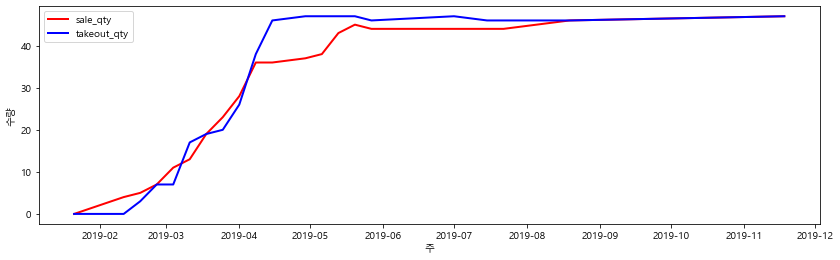

2019-03-11


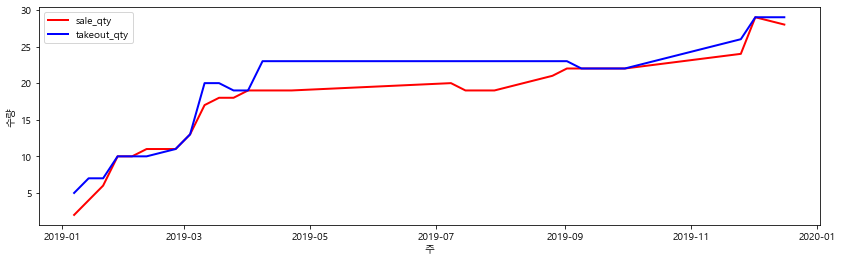

2019-03-18


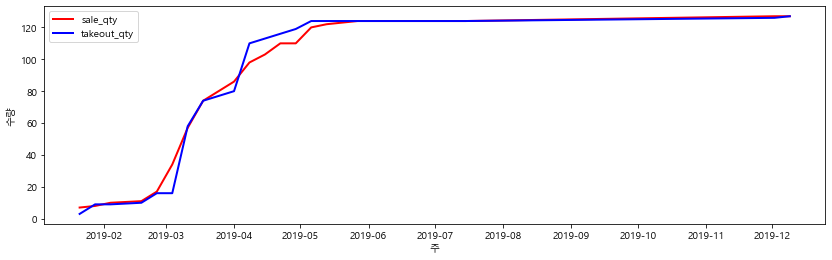

2019-03-18


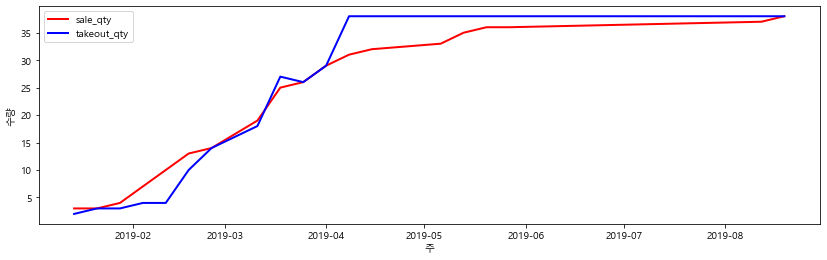

2019-03-18


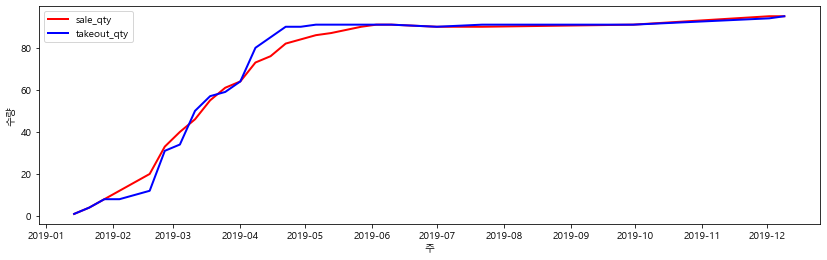

2019-03-18


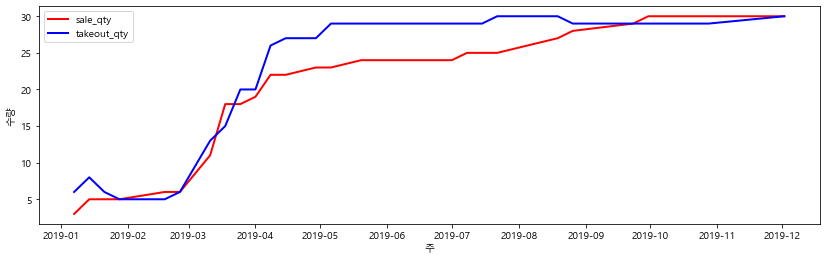

2019-03-18


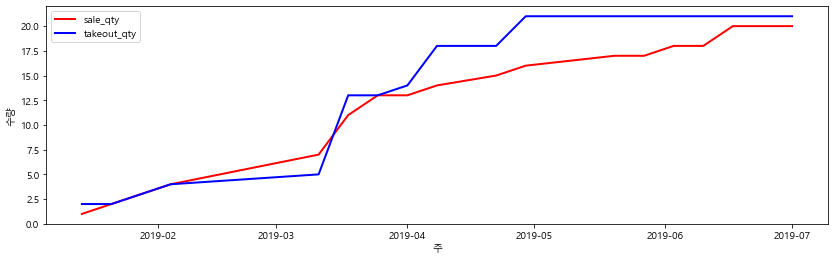

2019-03-18


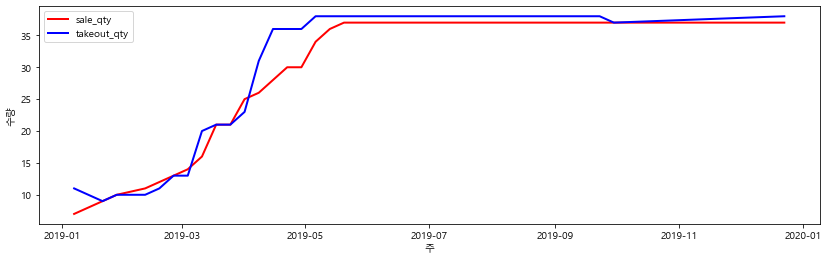

2019-04-01


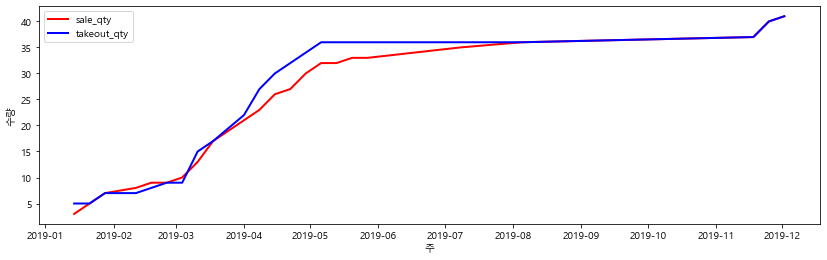

2019-04-29


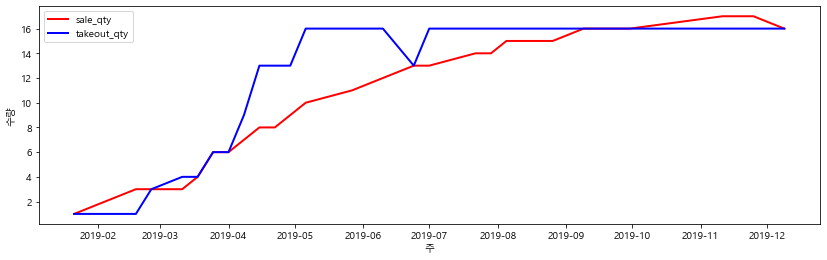

2019-03-25


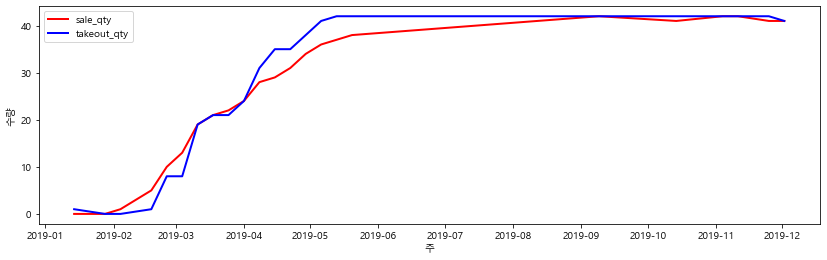

2019-03-25


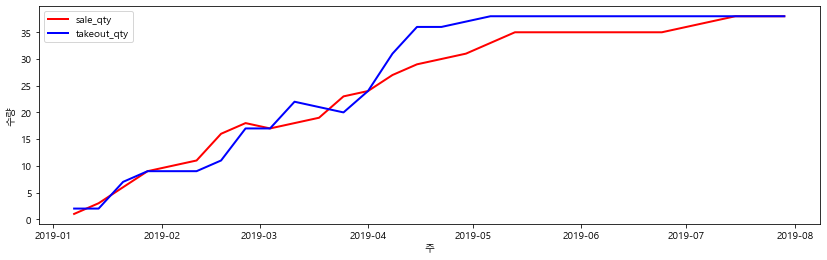

2019-03-25


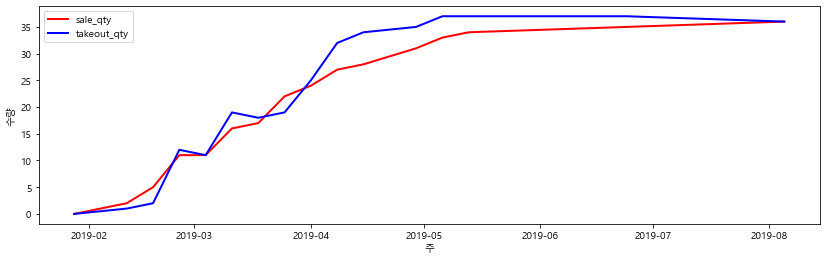

2019-06-17


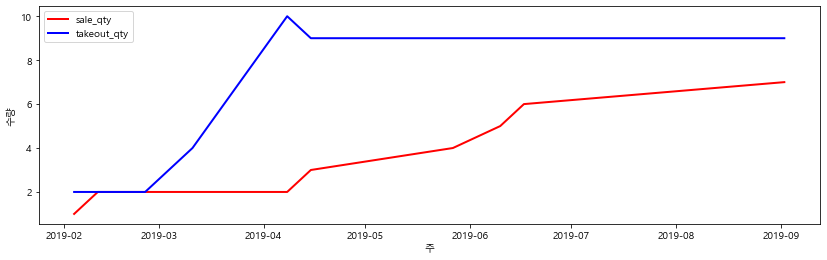

2019-04-08


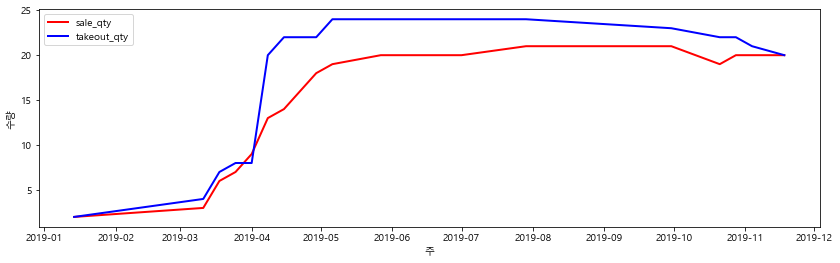

2019-04-08


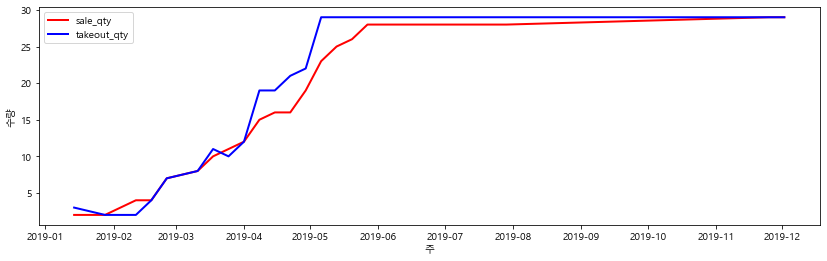

2019-04-29


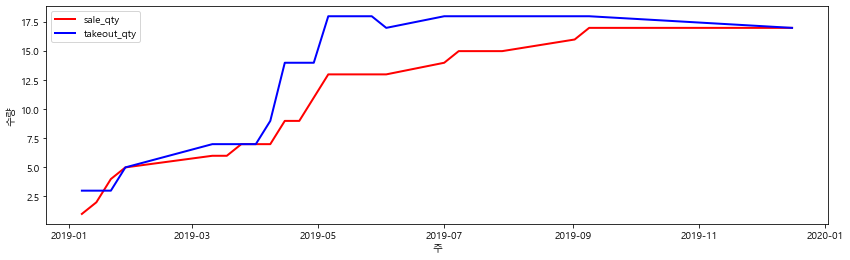

2019-04-22


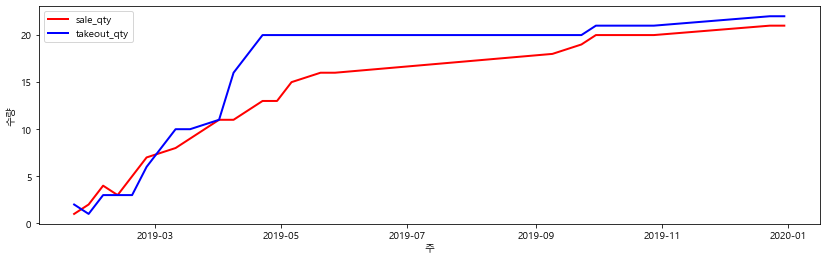

2019-04-22


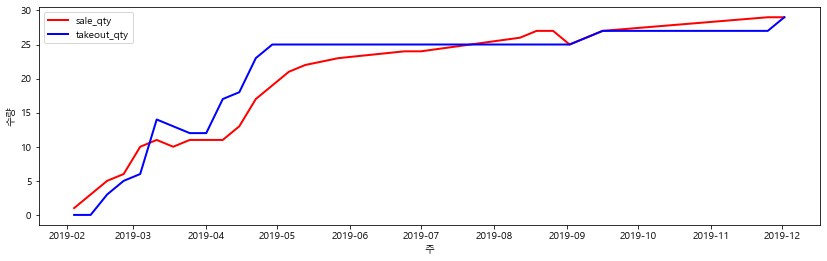

2019-05-06


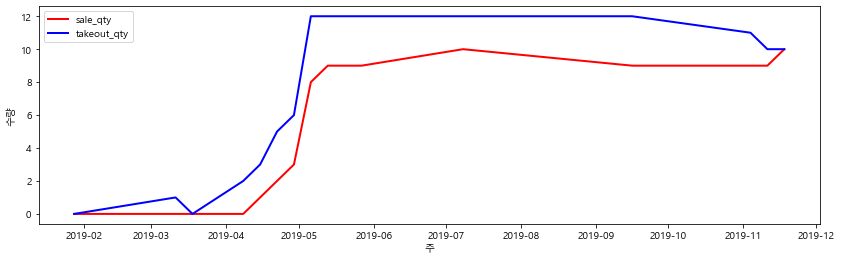

In [351]:
seoul_list=[]
for i in 서울[:20]:
    
    seoul= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['shopkey','weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
    seoul_join_df_2019 = pd.merge(seoul, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
    seoul_list.append(seoul_join_df_2019)
    plt.plot(seoul['weekkey'], seoul['sale_qty'],'r')
    plt.plot(seoul['weekkey'], seoul['takeout_qty'],'b')
    print(seoul[seoul['sale_qty']> seoul['takeout_qty'].max() / 2].iloc[0]['weekkey'])
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

2019-03-25


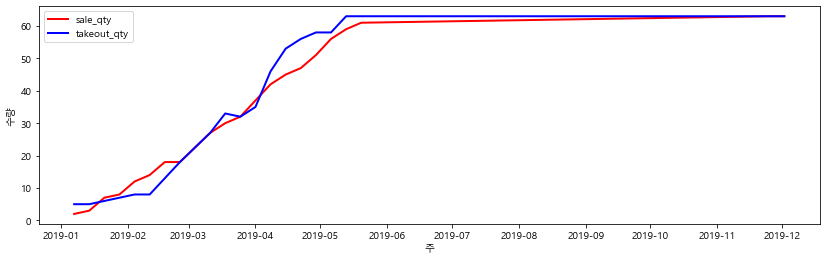

2019-04-01


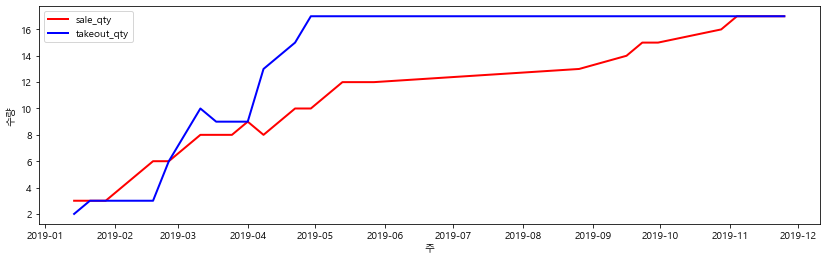

2019-02-25


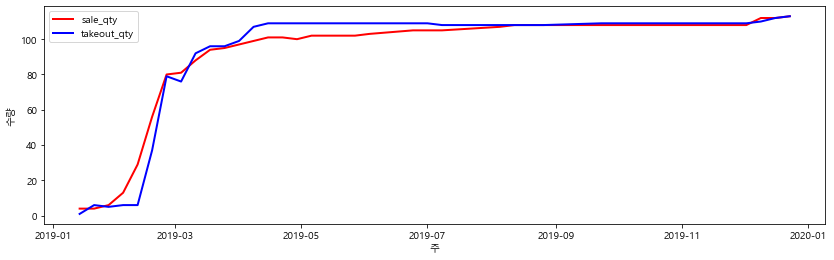

2019-03-04


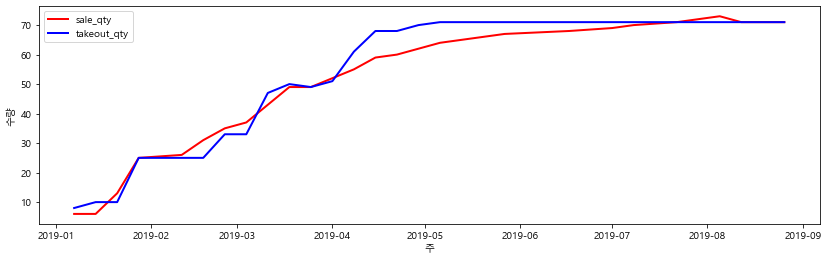

2019-04-22


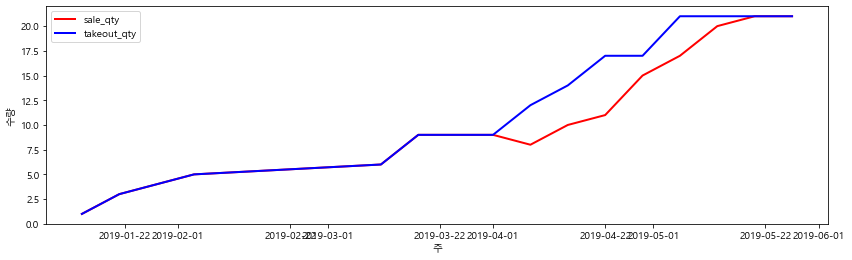

In [334]:
for i in 경기[:5]:
    
    seoul_list= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
    plt.plot(seoul_list['weekkey'], seoul_list['sale_qty'],'r')
    plt.plot(seoul_list['weekkey'], seoul_list['takeout_qty'],'b')
    print(seoul_list[seoul_list['sale_qty']> seoul_list['takeout_qty'].max() / 2].iloc[0]['weekkey'])
    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [344]:
seoul_list_pd = pd.concat(seoul_list)

In [345]:
seoul_list_pd

,shopkey,weekkey,week_takeout_qty,week_sale_qty,sale_qty,stock_qty,takeout_qty,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
0,X10008,2019-01-21,-1,0,0,0,0,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
1,X10008,2019-02-11,0,4,4,-4,0,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
2,X10008,2019-02-18,3,1,5,-2,3,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
3,X10008,2019-02-25,4,2,7,0,7,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
4,X10008,2019-03-04,0,4,11,-4,7,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
5,X10008,2019-03-11,10,2,13,4,17,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
6,X10008,2019-03-18,2,6,19,0,19,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
7,X10008,2019-03-25,1,4,23,-3,20,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
8,X10008,2019-04-01,6,5,28,-2,26,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울
9,X10008,2019-04-08,12,8,36,2,38,롯데건대,디스커버리 롯데 건대점,XH0200,일반매장,백화점특정,백화점,서울


In [346]:
seoul_list_pd.to_csv('seoul_list.csv')

In [347]:
daegu_list = []
for i in 대구[:5]:
    
    daegu= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['shopkey','weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
    daegu_join_df_2019 = pd.merge(daegu, shop_info_pd, left_on='shopkey', right_on='shopkey', how='inner')
    daegu_list.append(daegu_join_df_2019)
    
#     seoul_list= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
#     plt.plot(seoul_list['weekkey'], seoul_list['sale_qty'],'r')
#     plt.plot(seoul_list['weekkey'], seoul_list['takeout_qty'],'b')
#     print(seoul_list[seoul_list['sale_qty']> seoul_list['takeout_qty'].max() / 2].iloc[0]['weekkey'])
#     plt.legend(['sale_qty','takeout_qty'])
#     plt.xlabel('주')
#     plt.ylabel('수량')
#     plt.show()

In [348]:
daegu_list_pd = pd.concat(daegu_list)
daegu_list_pd.to_csv('daegu_list.csv')

2019-03-25


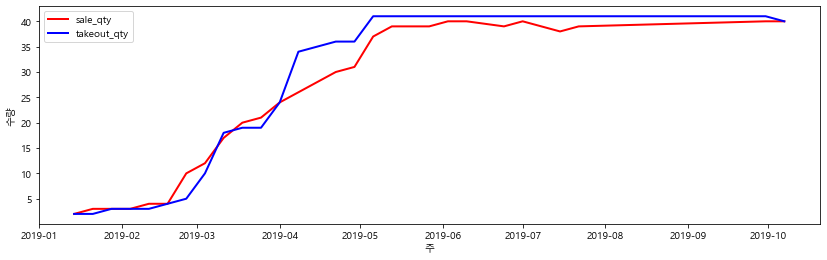

2019-03-04


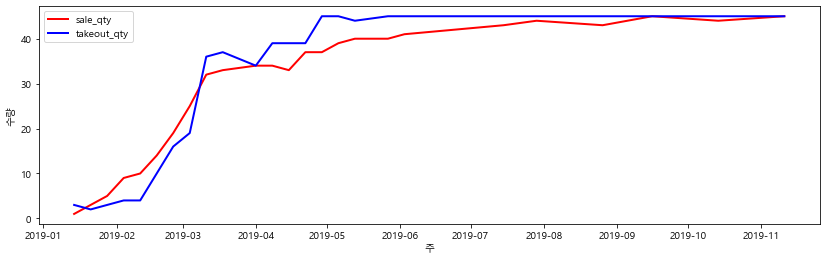

2019-04-22


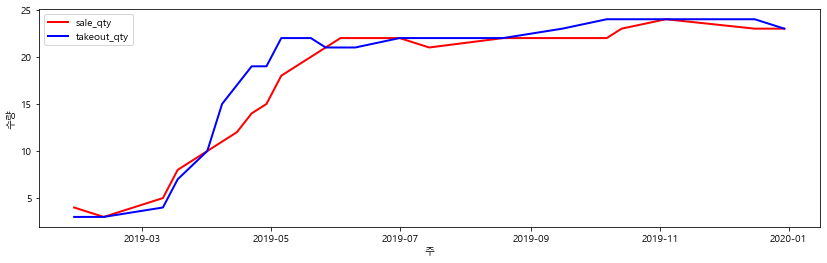

2019-03-04


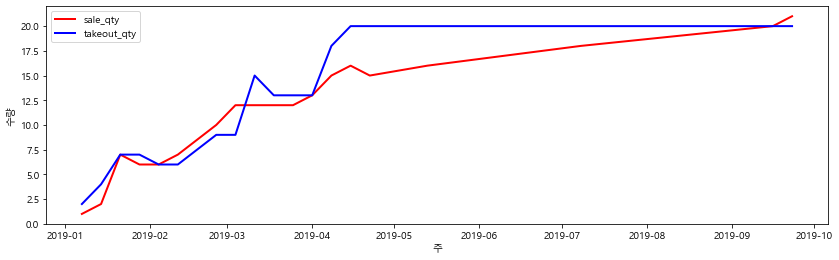

2019-03-11


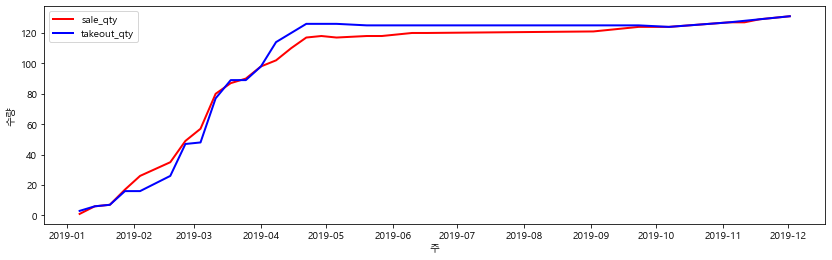

In [331]:
for i in 부산[:5]:
    
    seoul_list= shop_stock_2019[(shop_stock_2019['shopkey']==i) & (shop_stock_2019['scskey']=='X19SDXSH11911WH240') ].sort_values('weekkey')[['weekkey','week_takeout_qty','week_sale_qty','sale_qty','stock_qty','takeout_qty']].sort_values('weekkey')
    plt.plot(seoul_list['weekkey'], seoul_list['sale_qty'],'r')
    plt.plot(seoul_list['weekkey'], seoul_list['takeout_qty'],'b')
    seoul_list[seoul_list['sale_qty']> seoul_list['takeout_qty'].max() / 2].iloc[0]['weekkey']
    print(seoul_list[seoul_list['sale_qty']> seoul_list['takeout_qty'].max() / 2].iloc[0]['weekkey'])

    plt.legend(['sale_qty','takeout_qty'])
    plt.xlabel('주')
    plt.ylabel('수량')
    plt.show()

In [319]:
seoul_list['takeout_qty'].max()

,weekkey,week_takeout_qty,week_sale_qty,sale_qty,stock_qty,takeout_qty
1006457,2019-01-07,2,1,1,2,3
1006458,2019-01-14,3,5,6,0,6
1006459,2019-01-21,1,1,7,0,7
1006460,2019-01-28,9,10,17,-1,16
1010201,2019-02-04,0,9,26,-10,16
1006461,2019-02-18,10,9,35,-9,26
1008390,2019-02-25,21,14,49,-2,47
1006274,2019-03-04,1,8,57,-9,48
1010202,2019-03-11,29,23,80,-3,77
1010203,2019-03-18,12,7,87,2,89


In [327]:
seoul_list[seoul_list['sale_qty']> seoul_list['takeout_qty'].max() / 2].iloc[0]['weekkey']

datetime.date(2019, 3, 11)

In [335]:
seoul_list

,weekkey,week_takeout_qty,week_sale_qty,sale_qty,stock_qty,takeout_qty
138185,2019-01-14,0,1,1,0,1
138186,2019-01-21,2,2,3,0,3
138187,2019-01-28,1,1,4,0,4
130835,2019-02-04,1,1,5,0,5
130836,2019-03-11,1,1,6,0,6
130837,2019-03-18,3,3,9,0,9
130838,2019-04-01,0,0,9,0,9
130839,2019-04-08,3,-1,8,4,12
136443,2019-04-15,2,2,10,4,14
130840,2019-04-22,3,1,11,6,17


In [357]:
shop_stock_2019[shop_stock_2019['week_sale_amt'] > 0 ]['week_sale_amt'].mean()

122622.37746771851

In [358]:
shop_stock_2020[shop_stock_2020['week_sale_amt'] > 0 ]['week_sale_amt'].mean()

123147.49881030698

In [361]:
test2 = df_shop.sort_values('매장 내 재고가 0 인 경우(2020)')

In [372]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']].to_csv('df_shop_zero.csv')

In [373]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']]

,shopkey,주 별 총 판매량(2019),주 별 총 판매량(2020),주 별 총 입고량(2019),주 별 총 입고량(2020),판매수량 비율(20/19),입고수량 비율(20/19),매장 내 재고가 0 인 경우(2019),매장 내 재고가 0 인 경우(2020),shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
135,X10080,3179,2295,3470,2254,0.721925,0.649568,0.222022,0.156111,엔터6왕십리,디스커버리 엔터식스 왕십리점,XH0266,일반매장,백화점특정,백화점,서울
54,X50063,3322,4467,3471,4635,1.344672,1.335350,0.261974,0.186277,스퀘어원(대-위),디스커버리 스퀘어원점,XH0051,일반매장,대리점,대리점,인천
72,X30015,3714,4765,3907,4975,1.282983,1.273356,0.265696,0.186604,타임스퀘어(직),디스커버리 타임스퀘어점,XH3008,일반매장,직영점,직영점,서울
3,X10050,5722,11534,6405,12274,2.015729,1.916315,0.232193,0.186933,롯데본점,디스커버리 롯데 본점,XH0248,일반매장,백화점특정,백화점,서울
87,X10078,3215,3789,3654,3985,1.178538,1.090586,0.280379,0.188225,신세계김해,디스커버리 신세계 김해점,XH0264,일반매장,백화점특정,백화점,경남
122,X50121,2223,2097,2348,2210,0.943320,0.941227,0.282395,0.190892,청주성안(대-위),디스커버리 청주성안점,XH0109,일반매장,대리점,대리점,충북
94,X10035,3897,4451,4351,4740,1.142161,1.089405,0.268756,0.194207,신세계의정부,디스커버리 신세계 의정부점,XH0226,일반매장,백화점특정,백화점,경기
117,X10022,5708,5617,6284,5733,0.984057,0.912317,0.290042,0.201252,롯데광주,디스커버리 롯데 광주점,XH0213,일반매장,백화점특정,백화점,광주
66,X10021,3220,4231,3678,4539,1.313975,1.234095,0.255459,0.202034,신세계아라리오,디스커버리 신세계 아라리오점,XH0215,일반매장,백화점특정,백화점,충남
108,X10023,3819,4000,4102,4123,1.047395,1.005119,0.264405,0.202596,갤러리아대전,디스커버리 갤러리아 대전점,XH0219,일반매장,백화점특정,백화점,대전


In [369]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']]['입고수량 비율(20/19)'].mean()

1.1425819520390865

In [371]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']]['판매수량 비율(20/19)'].mean()

1.2473428166952205

In [367]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']]['매장 내 재고가 0 인 경우(2019)'].mean()

0.2992762096667902

In [368]:
test2[test2['판매수량 비율(20/19)']>test2['입고수량 비율(20/19)']]['매장 내 재고가 0 인 경우(2020)'].mean()

0.25200261855919326